## Adversarial attacks - hyperspectral model HybridSN
This notebook demonstrates FGSM and PGD adversarial attacks on the trained HybridSN model using the Indian Pines (IP) dataset.

In [115]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from sklearn.decomposition import PCA

from attacks.fgsm import FGSM
from attacks.pgd import PGD
from attacks.cw import CW
from attacks.deepfool import DeepFool

In [116]:
BATCH_SIZE = 8 # How many images to process at once
NUM_IMAGES = 256 # How many images to process in total
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check device
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
if NUM_IMAGES > 10249:
    raise ValueError("NUM_IMAGES must be less than or equal to 10249, the number of images in the dataset.")

In [117]:
# Load IP dataset and preprocess (PCA, patch extraction)
def load_ip_data():
    data_path = os.path.join(os.getcwd(), 'data', 'IndianPines')
    data = loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    # PCA
    pca = PCA(n_components=15, whiten=True)
    newX = np.reshape(data, (-1, data.shape[2]))
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (data.shape[0], data.shape[1], 15))
    return newX, labels

In [118]:
class PatchSet(Dataset):
    def __init__(self, data, gt, patch_size):
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data, ((p,p),(p,p),(0,0)), 'constant')
        self.label = np.pad(gt, (p,p), 'constant')
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [119]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

In [120]:
N_PCA = 15
PATCH_SIZE = 25
NUM_CLASS = 16

model = HybridSN(N_PCA, PATCH_SIZE, class_nums=NUM_CLASS)
model.load_state_dict(torch.load('model/ip_final_weights.pth', map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Prepare test data
ip_data, ip_labels = load_ip_data()
test_gt = (ip_labels > 0).astype(np.int64) * ip_labels
test_data = PatchSet(ip_data, test_gt, PATCH_SIZE)
test_data = torch.utils.data.Subset(test_data, range(NUM_IMAGES))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## Fixed parameters

In [ ]:
# FGSM
FGSM_EPSILON = 0.01

# PGD
PGD_EPSILON = 0.01
PGD_ALPHA = 0.003
PGD_STEPS = 1

# CW
CW_C = 1
CW_KAPPA = 0
CW_STEPS = 10
CW_LR = 0.005

# DeepFool
DF_STEPS = 1
DF_OVERSHOOT = 0.01
NUM_CLASSES = NUM_CLASS

## FGSM Attack
Apply FGSM to the test set and evaluate the model's accuracy on adversarial examples.

In [122]:
fgsm = FGSM(model, eps=FGSM_EPSILON, clip_min=0.0, clip_max=1.0)
fgsm_acc = None
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = fgsm(data, target)
    output = model(adv_data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

fgsm_acc = correct / total

## PGD Attack
Apply PGD to the test set and evaluate the model's accuracy on adversarial examples.

In [123]:
pgd = PGD(model, eps=PGD_EPSILON, alpha=PGD_ALPHA, steps=PGD_STEPS, clip_min=0.0, clip_max=1.0)
pgd_acc = None
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = pgd(data, target)
    output = model(adv_data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

pgd_acc = correct / total

## CW Attack
Apply CW to the test set and evaluate the model's accuracy on adversarial examples.

In [124]:
cw = CW(model, c=CW_C, kappa=CW_KAPPA, steps=CW_STEPS, lr=CW_LR, clip_min=0.0, clip_max=1.0)
df_cw_acc = None
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = cw(data, target)
    output = model(adv_data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

df_cw_acc = correct / total

## DeepFool Attack
Apply DeepFool to the test set and evaluate the model's accuracy on adversarial examples.

In [125]:
deepfool = DeepFool(model, steps=DF_STEPS, overshoot=DF_OVERSHOOT, num_classes=NUM_CLASSES, clip_min=0.0, clip_max=1.0)
df_deepfool_acc = None
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = deepfool(data, target)
    output = model(adv_data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

df_deepfool_acc = correct / total

## Clean accuracy
Calculate accuracy on clean images for comparison

In [126]:
# Compute clean accuracy
correct = 0
total = 0

for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    output = model(data)
    _, pred = torch.max(output, 1)
    correct += (pred == target).sum().item()
    total += target.size(0)

clean_acc = correct / total

## Results
Display accuracies of FGSM, PGD, CW, DeepFool attacks versus clean accuracy.

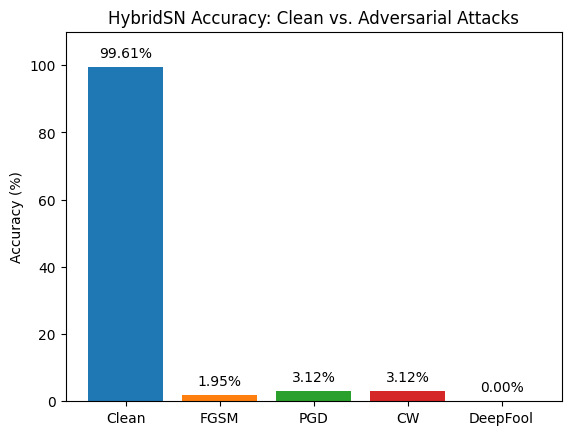

In [127]:
# Plot histogram with y-axis in percent and value labels
labels = ['Clean', 'FGSM', 'PGD', 'CW', 'DeepFool']
accuracies = [clean_acc, fgsm_acc, pgd_acc, df_cw_acc, df_deepfool_acc]
percentages = [a * 100 for a in accuracies]
bars = plt.bar(labels, percentages, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim(0, 110)
plt.ylabel('Accuracy (%)')
plt.title('HybridSN Accuracy: Clean vs. Adversarial Attacks')

# Add value labels
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{pct:.2f}%', ha='center', va='bottom')

plt.show()

In [128]:
print(f'Clean Accuracy: {clean_acc:.4f}')
print(f'FGSM Accuracy: {fgsm_acc:.4f}')
print(f'PGD Accuracy: {pgd_acc:.4f}')
print(f'CW Accuracy: {df_cw_acc:.4f}')
print(f'DeepFool Accuracy: {df_deepfool_acc:.4f}')

Clean Accuracy: 0.9961
FGSM Accuracy: 0.0195
PGD Accuracy: 0.0312
CW Accuracy: 0.0312
DeepFool Accuracy: 0.0000


Average perturbation magnitude (L2 norm, Linf norm):
FGSM: L2 = 53.1181, Linf = 4.1143
PGD: L2 = 53.1146, Linf = 4.1143
CW: L2 = 52.0708, Linf = 4.0153
DeepFool: L2 = 53.1924, Linf = 4.1143


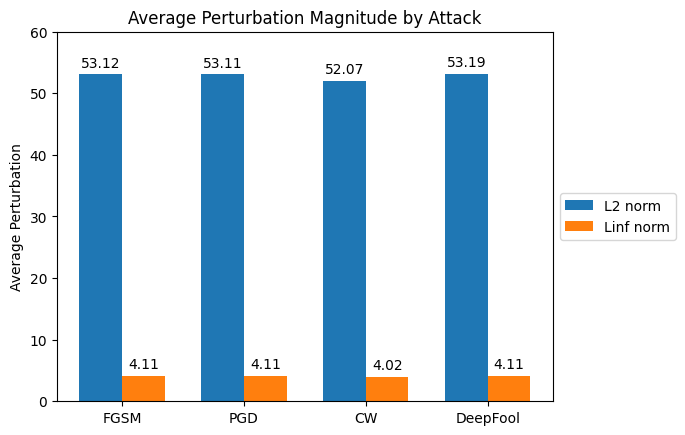

In [129]:
# Compute and compare average perturbation magnitudes for each attack
perturbation_results = {}

# FGSM perturbation
fgsm_l2 = []
fgsm_linf = []
for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = fgsm(data, target)
    perturb = (adv_data - data).view(data.size(0), -1)
    fgsm_l2.extend(torch.norm(perturb, p=2, dim=1).cpu().numpy())
    fgsm_linf.extend(torch.norm(perturb, p=float('inf'), dim=1).cpu().numpy())
perturbation_results['FGSM'] = (np.mean(fgsm_l2), np.mean(fgsm_linf))

# PGD perturbation
pgd_l2 = []
pgd_linf = []
for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = pgd(data, target)
    perturb = (adv_data - data).view(data.size(0), -1)
    pgd_l2.extend(torch.norm(perturb, p=2, dim=1).cpu().numpy())
    pgd_linf.extend(torch.norm(perturb, p=float('inf'), dim=1).cpu().numpy())
perturbation_results['PGD'] = (np.mean(pgd_l2), np.mean(pgd_linf))

# CW perturbation
cw_l2 = []
cw_linf = []
for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = cw(data, target)
    perturb = (adv_data - data).view(data.size(0), -1)
    cw_l2.extend(torch.norm(perturb, p=2, dim=1).cpu().numpy())
    cw_linf.extend(torch.norm(perturb, p=float('inf'), dim=1).cpu().numpy())
perturbation_results['CW'] = (np.mean(cw_l2), np.mean(cw_linf))

# DeepFool perturbation
deepfool_l2 = []
deepfool_linf = []
for data, target in test_loader:
    data, target = data.to(DEVICE), (target-1).to(DEVICE)
    adv_data = deepfool(data, target)
    perturb = (adv_data - data).view(data.size(0), -1)
    deepfool_l2.extend(torch.norm(perturb, p=2, dim=1).cpu().numpy())
    deepfool_linf.extend(torch.norm(perturb, p=float('inf'), dim=1).cpu().numpy())
perturbation_results['DeepFool'] = (np.mean(deepfool_l2), np.mean(deepfool_linf))

# Print results
print('Average perturbation magnitude (L2 norm, Linf norm):')
for attack, (l2, linf) in perturbation_results.items():
    print(f'{attack}: L2 = {l2:.4f}, Linf = {linf:.4f}')

# Plot bar chart for L2 and Linf
labels = list(perturbation_results.keys())
l2_vals = [perturbation_results[k][0] for k in labels]
linf_vals = [perturbation_results[k][1] for k in labels]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l2_vals, width, label='L2 norm')
rects2 = ax.bar(x + width/2, linf_vals, width, label='Linf norm')

ax.set_ylabel('Average Perturbation')
ax.set_title('Average Perturbation Magnitude by Attack')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 60)

for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
plt.show()